In [229]:
from loader1 import *
from utils import *
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
_ = load_all()

Some files already exist in your CACHE_DIR. If you still want to run this function,              run with override=True


In [115]:
gps = read_data('gps')
orders = read_data('order')

In [116]:
gps.shape, orders.shape

((32155517, 5), (209423, 7))

In [117]:
# dropping duplicates
orders = orders.drop_duplicates()
gps = gps.drop_duplicates()

In [220]:
orders.shape

(181172, 9)

In [118]:
# Run util functions
gps = convert_unix_ts(gps, timecols=['timestamp'])
orders = convert_unix_ts(orders, timecols=['ride_start_timestamp', 'ride_stop_timestamp'])
orders = ride_duration(orders)

In [119]:
# Add driverid in orders column
drivers = gps[['driver_id', 'order_id']].drop_duplicates()
orders = orders.merge(drivers, on='order_id', how='left')

In [120]:
driver_start_times = orders.loc[:, ['driver_id', 'ride_start_timestamp', 'ride_stop_timestamp', 'order_id']].drop_duplicates()

In [121]:
driver_start_times.sort_values(['driver_id', 'ride_start_timestamp'], inplace=True)

In [122]:
driver_start_times['stop_time_shifted'] = driver_start_times.groupby('driver_id')['ride_stop_timestamp'].shift(1)

In [123]:
driver_start_times['diff'] = driver_start_times['ride_start_timestamp'] - driver_start_times['stop_time_shifted']

In [124]:
# Rows where difference is negative indicating that there is an overlap 

negative_difference_rows = driver_start_times[driver_start_times['stop_time_shifted'] > driver_start_times['ride_start_timestamp']].dropna()

In [125]:
negative_difference_rows.shape

(6047, 6)

In [126]:
negative_difference_rows.head(2)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
63464,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:49:50,2016-11-01 13:10:00,0bb417e0e260876d3c7b6d7afc7e0c7f,2016-11-01 13:24:56,-1 days +23:24:54
63465,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:53:13,2016-11-01 13:51:06,dc90a199ba3767ee64c7b24c0835811d,2016-11-01 13:10:00,-1 days +23:43:13


In [127]:
list_of_drivers = set(negative_difference_rows['driver_id'].drop_duplicates())

In [128]:
len(list_of_drivers)

4873

In [129]:
driver_start_times.head(15)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
80898,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 03:57:05,2016-11-01 04:13:18,f727597b61fc2f0141aadecf2a3b5ee0,NaT,NaT
80899,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 04:33:05,2016-11-01 04:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 04:13:18,00:19:47
80897,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 04:58:45,2016-11-01 05:42:08,dd9b252638479fb784b705492bdf1a65,2016-11-01 04:49:04,00:09:41
63461,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 01:29:41,2016-11-01 01:45:47,7a4833b8e39db563365e485f3c16feb5,NaT,NaT
63462,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:06:55,2016-11-01 12:28:25,32eb295835b821f4b01c9eb9292bd534,2016-11-01 01:45:47,10:21:08
63463,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:43:34,2016-11-01 13:24:56,1bd834f316b12c5f76848a7382c554e9,2016-11-01 12:28:25,00:15:09
63464,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:49:50,2016-11-01 13:10:00,0bb417e0e260876d3c7b6d7afc7e0c7f,2016-11-01 13:24:56,-1 days +23:24:54
63465,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:53:13,2016-11-01 13:51:06,dc90a199ba3767ee64c7b24c0835811d,2016-11-01 13:10:00,-1 days +23:43:13
135691,000770ada4aa5d856b5a766fb6bf7cf1,2016-11-01 01:04:52,2016-11-01 01:39:51,7f543d0715adc066cd7b9126ed3f5551,NaT,NaT
135692,000770ada4aa5d856b5a766fb6bf7cf1,2016-11-01 02:54:03,2016-11-01 03:12:19,1855095fcf3128788ebe05c47f9e6932,2016-11-01 01:39:51,01:14:12


In [130]:
driver_start_times.head(2)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
80898,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 03:57:05,2016-11-01 04:13:18,f727597b61fc2f0141aadecf2a3b5ee0,NaT,NaT
80899,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 04:33:05,2016-11-01 04:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 04:13:18,00:19:47


In [131]:
orders.head()

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
0,eb9dd4095d9850e6287cefd813775a6c,2016-11-01 01:46:37,2016-11-01 02:15:07,104.094640,30.703971,104.089270,30.650850,28.500000,0373c98625e6d8e1fc56a4d61318138c
1,387a742fa5a3fbe4a1f215ac58ea33a8,2016-11-01 07:33:05,2016-11-01 08:07:55,104.076509,30.767430,104.063700,30.589510,34.833333,0373c98625e6d8e1fc56a4d61318138c
2,9cf55f8e6e02a1e0f792df06e5d85011,2016-11-01 12:55:52,2016-11-01 13:16:57,104.019699,30.689007,104.105324,30.663950,21.083333,0373c98625e6d8e1fc56a4d61318138c
3,5feeae0307e15203484b9ffceef89855,2016-11-01 08:44:00,2016-11-01 09:04:25,104.036090,30.622690,104.043860,30.682320,20.416667,0373c98625e6d8e1fc56a4d61318138c
4,ad4b52cb15b90c44c8f20a8b1e57a622,2016-10-31 23:53:25,2016-11-01 00:02:57,104.115997,30.652313,104.104421,30.695113,9.533333,0373c98625e6d8e1fc56a4d61318138c


In [132]:
driver_ride_durations = orders.groupby('driver_id')[['ride_duration']].sum().reset_index()

### Single day total active time

In [134]:
driver_day_min = pd.DataFrame(orders.groupby('driver_id')['ride_start_timestamp'].min()).reset_index()
driver_day_max = pd.DataFrame(orders.groupby('driver_id')['ride_stop_timestamp'].max()).reset_index()
driver_active_time = driver_day_min.merge(driver_day_max, on='driver_id', how='left')
driver_active_time['active_time'] = (driver_active_time['ride_stop_timestamp'] - driver_active_time['ride_start_timestamp']).dt.total_seconds() / 60
driver_active_time.head()

,driver_id,ride_start_timestamp,ride_stop_timestamp,active_time
0,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 03:57:05,2016-11-01 05:42:08,105.050000
1,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 01:29:41,2016-11-01 13:51:06,741.416667
2,000770ada4aa5d856b5a766fb6bf7cf1,2016-11-01 01:04:52,2016-11-01 04:19:01,194.150000
3,0007a380800445346fff19afc4071ce3,2016-11-01 01:30:40,2016-11-01 01:54:19,23.650000
4,0008c9d2ac91c00ef8b3ef80eba02a06,2016-11-01 02:23:26,2016-11-01 16:07:35,824.150000


### Comparing total driver active time vs ride time

In [185]:
# total driver active time
driver_stats = driver_active_time[['driver_id', 'active_time']].merge(driver_ride_durations, on='driver_id', how='left') 

# Filtering possible bad rows
driver_stats[driver_stats.active_time < driver_stats.ride_duration].describe()

,active_time,ride_duration
count,489.000000,489.000000
mean,83.387355,100.011350
std,47.657819,50.247266
min,11.850000,20.800000
25%,53.416667,68.466667
50%,73.783333,92.233333
75%,100.300000,117.283333
max,448.683333,477.183333


In [142]:
list_of_drivers_with_less_active_time = set(driver_stats[driver_stats.active_time < driver_stats.ride_duration]['driver_id'].drop_duplicates())

In [143]:
len(list_of_drivers_with_less_active_time)

489

In [144]:
len(list_of_drivers.intersection(list_of_drivers_with_less_active_time))

489

The above indicates that every driver with this issue had an overlap in his ride. There were roughly 4400 other drives who had this issue as well but their active time was less than their ride duration

In [145]:
other_drivers = list_of_drivers_with_less_active_time.difference(list_of_drivers)

In [146]:
other_drivers

set()

In [147]:
driver_stats.head(2)

,driver_id,active_time,ride_duration
0,0000131d486b69eb77ab6e9e7cca9f4c,105.050000,75.583333
1,000211a97ba2b768ef941593bf1ae1a5,741.416667,157.016667


Now using the difference, we will see whether there are drivers with gaps fo more than 1 hour between their rides. If so we will further reduce their active time since it might be that they would have taken breaks for lunch during the day

In [168]:
drivers_with_greater_than_an_hour_break = driver_start_times[driver_start_times['diff'].dt.total_seconds() > 3600]

In [171]:
drivers_with_greater_than_an_hour_break.head(3)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
63462,000211a97ba2b768ef941593bf1ae1a5,2016-11-01 12:06:55,2016-11-01 12:28:25,32eb295835b821f4b01c9eb9292bd534,2016-11-01 01:45:47,10:21:08
135692,000770ada4aa5d856b5a766fb6bf7cf1,2016-11-01 02:54:03,2016-11-01 03:12:19,1855095fcf3128788ebe05c47f9e6932,2016-11-01 01:39:51,01:14:12
160893,0008c9d2ac91c00ef8b3ef80eba02a06,2016-11-01 07:12:44,2016-11-01 07:17:45,1becf86f0a4dbb32ecbbb522d3e1e64b,2016-11-01 03:31:20,03:41:24


In [169]:
drivers_with_greater_than_an_hour_break.shape

(27614, 6)

In [195]:
total_inactive_time = drivers_with_greater_than_an_hour_break.groupby('driver_id')['diff'].sum().reset_index()
total_inactive_time['inactive_time'] = total_inactive_time['diff'].dt.total_seconds()/60

In [196]:
total_inactive_time.shape

(18122, 3)

In [197]:
total_inactive_time.head(5)

,driver_id,diff,inactive_time
0,000211a97ba2b768ef941593bf1ae1a5,10:21:08,621.133333
1,000770ada4aa5d856b5a766fb6bf7cf1,01:14:12,74.200000
2,0008c9d2ac91c00ef8b3ef80eba02a06,10:14:32,614.533333
3,000d0e4bd461b1f964daeb6d21868757,15:58:53,958.883333
4,000d7d7fe559c61e98d0a51e23e69bf7,03:14:44,194.733333


In [266]:
driver_stats_updated = driver_stats.merge(total_inactive_time[['driver_id', 'inactive_time']], on='driver_id', how='left').fillna(0)
driver_stats_updated['modified_active_time'] = driver_stats_updated['active_time'] - driver_stats_updated['inactive_time']
driver_stats_updated['modified_active_time_with_rules'] = driver_stats_updated['active_time'] - np.where((driver_stats_updated['inactive_time'] > 240) | (driver_stats_updated['inactive_time'] == 0 ), driver_stats_updated['inactive_time'], 60)
driver_stats_updated.head(10)

,driver_id,active_time,ride_duration,inactive_time,modified_active_time,modified_active_time_with_rules
0,0000131d486b69eb77ab6e9e7cca9f4c,105.050000,75.583333,0.000000,105.050000,105.050000
1,000211a97ba2b768ef941593bf1ae1a5,741.416667,157.016667,621.133333,120.283333,120.283333
2,000770ada4aa5d856b5a766fb6bf7cf1,194.150000,87.900000,74.200000,119.950000,134.150000
3,0007a380800445346fff19afc4071ce3,23.650000,23.650000,0.000000,23.650000,23.650000
4,0008c9d2ac91c00ef8b3ef80eba02a06,824.150000,142.766667,614.533333,209.616667,209.616667
5,00095da02ea38d4d8eaa120201e38ae9,25.366667,25.366667,0.000000,25.366667,25.366667
6,000d0e4bd461b1f964daeb6d21868757,1114.050000,130.500000,958.883333,155.166667,155.166667
7,000d7d7fe559c61e98d0a51e23e69bf7,578.250000,272.883333,194.733333,383.516667,518.250000
8,000db06fb2f4a700c4105348643f593e,19.350000,19.350000,0.000000,19.350000,19.350000
9,000f63bea1c5b36b439d6fa60ee6cac7,564.366667,183.166667,338.916667,225.450000,225.450000


In [260]:
driver_stats_updated.describe()

,active_time,ride_duration,inactive_time,modified_active_time
count,35449.000000,35449.000000,35449.000000,35449.000000
mean,339.820956,110.729417,190.999581,166.151498
std,342.241304,84.044857,287.326912,137.189493
min,0.066667,0.066667,0.000000,0.066667
25%,60.616667,44.533333,0.000000,55.316667
50%,218.300000,89.066667,65.050000,129.850000
75%,536.850000,156.600000,288.266667,242.016667
max,1509.083333,677.566667,1401.650000,911.733333


In [267]:
list_of_drivers_with_less_active_time = set(driver_stats_updated[np.round(driver_stats_updated.ride_duration/driver_stats_updated.modified_active_time, 2) > 1]['driver_id'].drop_duplicates())

In [268]:
print(len(list_of_drivers_with_less_active_time))
len(list_of_drivers.intersection(list_of_drivers_with_less_active_time))

1125


1125

In [269]:
other_drivers = list_of_drivers_with_less_active_time.difference(list_of_drivers)

In [281]:
orders[orders['driver_id'] == '000211a97ba2b768ef941593bf1ae1a5']

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
63461,7a4833b8e39db563365e485f3c16feb5,2016-11-01 01:29:41,2016-11-01 01:45:47,104.01616,30.67141,104.060430,30.670650,16.100000,000211a97ba2b768ef941593bf1ae1a5
63462,32eb295835b821f4b01c9eb9292bd534,2016-11-01 12:06:55,2016-11-01 12:28:25,104.05099,30.63277,104.118610,30.661450,21.500000,000211a97ba2b768ef941593bf1ae1a5
63463,1bd834f316b12c5f76848a7382c554e9,2016-11-01 12:43:34,2016-11-01 13:24:56,104.12024,30.66279,104.136750,30.609250,41.366667,000211a97ba2b768ef941593bf1ae1a5
63464,0bb417e0e260876d3c7b6d7afc7e0c7f,2016-11-01 12:49:50,2016-11-01 13:10:00,104.11256,30.66713,104.116592,30.642699,20.166667,000211a97ba2b768ef941593bf1ae1a5
63465,dc90a199ba3767ee64c7b24c0835811d,2016-11-01 12:53:13,2016-11-01 13:51:06,104.11101,30.66978,104.056580,30.531100,57.883333,000211a97ba2b768ef941593bf1ae1a5


In [270]:
orders[orders['driver_id'] == '0050696e4d0dc155665ca7da5babc12c']

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
125657,fcbedec502f7345f9e31e772740a2282,2016-11-01 03:57:24,2016-11-01 04:21:34,104.037900,30.683320,104.054050,30.761350,24.166667,0050696e4d0dc155665ca7da5babc12c
125658,bff057039ae8c8f7bf4178b58e2f3859,2016-11-01 02:45:32,2016-11-01 03:21:23,104.065901,30.684108,103.956000,30.672830,35.850000,0050696e4d0dc155665ca7da5babc12c
125659,5532e75ce163bc39f5ca89627dff36e1,2016-11-01 01:30:16,2016-11-01 01:45:16,104.076576,30.713537,104.092228,30.684789,15.000000,0050696e4d0dc155665ca7da5babc12c
125660,6b9ca0e1b350b3033752ee5ff9f22179,2016-11-01 01:50:26,2016-11-01 02:04:17,104.092000,30.684420,104.090810,30.646880,13.850000,0050696e4d0dc155665ca7da5babc12c
125661,c37ace2710a48971a9b43e355edb5d46,2016-11-01 02:11:19,2016-11-01 02:26:38,104.093820,30.646280,104.074390,30.670470,15.316667,0050696e4d0dc155665ca7da5babc12c
125662,4c2696252361d0b22c6885d0abff9f8c,2016-11-01 02:30:35,2016-11-01 02:36:44,104.075600,30.671690,104.073590,30.685470,6.150000,0050696e4d0dc155665ca7da5babc12c
125663,13b14221c53516781bf24bba4a6fa1d9,2016-11-01 02:40:55,2016-11-01 03:09:38,104.072400,30.682310,104.001490,30.671570,28.716667,0050696e4d0dc155665ca7da5babc12c


In [13]:
orders[orders['order_id'] == 'dd9b252638479fb784b705492bdf1a65'].drop_duplicates()

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
93444,dd9b252638479fb784b705492bdf1a65,2016-11-01 04:58:45,2016-11-01 05:42:08,104.11077,30.6595,104.10318,30.64303,43.383333,0000131d486b69eb77ab6e9e7cca9f4c


## Scatter plot

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline

First we plot the active time vs the ride duration

[]

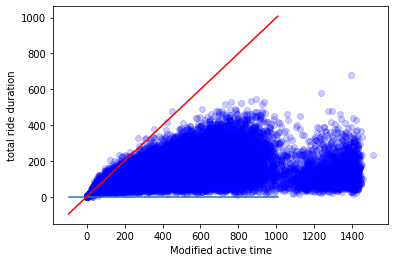

In [275]:
plt.scatter(driver_stats_updated['active_time'], driver_stats_updated['ride_duration'], c='b', alpha=0.2)
plt.ylabel('total ride duration')
plt.xlabel('Modified active time')
x = np.linspace(*ax.get_xlim())
plt.plot(x, [0]*len(x))
plt.plot(x, x, color='red')
plt.plot()

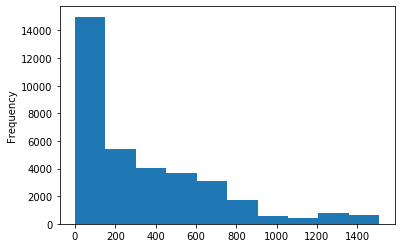

In [279]:
driver_stats_updated['active_time'].plot.hist()

From the above 2 graphs, it shows that a driver has been really active for more than 20 hours. This seems to indicate that the driver worked really late in the night and then came back in the morning. This actually should be removed from the data

Now when we subtract the periods where the inactivity of a driver was greater than an hour. This would seem to indicate that the driver turned off the app to have lunch or dinner. 

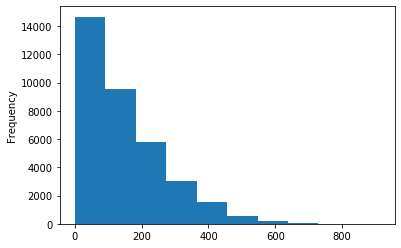

In [280]:
driver_stats_updated['modified_active_time'].plot.hist()

Our hypothesis is proven correct and the significant values in the tail have been removed

We next plot the modfied active time with ride duration

[]

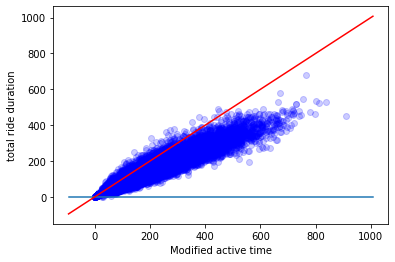

In [273]:
#fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.scatter(driver_stats_updated['modified_active_time'], driver_stats_updated['ride_duration'], c='b', alpha=0.2)
plt.ylabel('total ride duration')
plt.xlabel('Modified active time')
x = np.linspace(*ax.get_xlim())
plt.plot(x, [0]*len(x))
plt.plot(x, x, color='red')
plt.plot()

One issue with this scenario that we thought of was that a driver could pick up 2 rides in a day with a difference between them being greater than an hour. This would indicate that the driver was active for the whole period by our logic. So we created a rule where if the period of inactivity was less than 4 hours, we would only count his period of inactivity to be an hour. For greater than 4 hours, the whole period is considered inactive

[]

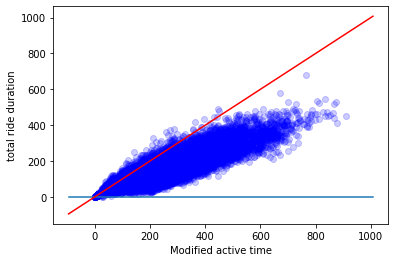

In [274]:
# fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.scatter(driver_stats_updated['modified_active_time_with_rules'], driver_stats_updated['ride_duration'], c='b', alpha=0.2)
plt.ylabel('total ride duration')
plt.xlabel('Modified active time')
x = np.linspace(*ax.get_xlim())
plt.plot(x, [0]*len(x))
plt.plot(x, x, color='red')
plt.plot()